In [9]:
%load_ext autoreload
%autoreload 2
%pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/tornikeo/Documents/work/scalexa/pangeaai/optimize-cosine'

In [11]:
from cudams.utils import argbatch, mkdir, get_ref_spectra_from_df
from cudams.similarity.kernels import cosine_greedy_kernel
# from cudams.utils import name2idx
# from cudams.cosine import similarity
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
# from cudams.data import spectra_peaks_to_tensor
from itertools import product
from time import perf_counter
# from multiprocessing.pool import ThreadPool
# from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from numba import cuda

assert cuda.is_available()

In [34]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 1024

# MAX NUMBER OF PEAKS during filtering. Due to nature of matrices, having large number of 
# peaks will increase memory requirements. After 1024, this has diminishing benefits, as 
# smaller and smaller (likely noisy) peaks are taken into consideration when running similarity.
MAX_PEAKS = 1024

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 1024

# Since Greedy cosine is an unstable algorithm, because approximate mz-mz values do not
# result in approximately the same scores and number of matches.
# So we need to use fp64 to minimize the deviation as much as possible.
# Using float32 causes a significant speedup in the processing speed.
dtype = 'float32'

score_threshold = .75

# Data path
reference_csv_file = Path("data/input/example_dataset_tornike.csv")
query_csv_file = Path("data/input/example_dataset_tornike.csv")

In [30]:
from cudams.utils import get_spectra_batches

references, queries, batches_inputs = get_spectra_batches(
    batch_size=BATCH_SIZE,
    max_peaks=MAX_PEAKS,
    max_pairs=64 * (BATCH_SIZE ** 2),
    padding=None,
)
TOTAL_BATCHES = len(batches_inputs)
batch_outputs = np.empty(shape=(TOTAL_BATCHES,4),dtype=object)

100%|██████████| 16384/16384 [00:04<00:00, 3304.14it/s]


In [54]:
from cudams.similarity.kernels import cosine_greedy_kernel

kernel = compile_cuda_cosine_greedy_kernel(
    tolerance=tolerance,
    shift=shift,
    mz_power=mz_power,
    int_power=int_power,
    match_limit=MATCH_LIMIT,
    batch_size=BATCH_SIZE
)

In [55]:
R, Q = BATCH_SIZE, BATCH_SIZE
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(R / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(Q / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)
THREADS_PER_BLOCK, BLOCKS_PER_GRID

((32, 32), (32, 32))

In [56]:
for batch_i in tqdm(range(len(batches_inputs))):
    
    (rspec, rlen, rstart, rend), (qspec, qlen, qstart, qend) = batches_inputs[
        batch_i
    ]
    
    lens = np.zeros((2, BATCH_SIZE), "int32")
    lens[0, : len(rlen)] = rlen
    lens[1, : len(qlen)] = qlen

    # We make sure main resources remain on CPU RAM
    with cuda.pinned(
        rspec,
        qspec,
        lens
    ):
        # We order empty space for results on GPU RAM
        out_cu = cuda.device_array(
            (BATCH_SIZE, BATCH_SIZE, 2), dtype="float32",
        )
        overflow_cu = cuda.device_array(
            (BATCH_SIZE, BATCH_SIZE, 1), dtype="uint8",
        )

        # We order the stream to copy input data to GPU RAM
        rspec_cu = cuda.to_device(rspec)
        qspec_cu = cuda.to_device(qspec)
        lens_cu = cuda.to_device(lens)

        # We order the stream to execute kernel (this is scheduled, it will execute, but we can't force it)
        kernel(
            rspec_cu, qspec_cu, lens_cu, out_cu, overflow_cu,
        )
            
        # We wait for all streams to finish their work everywhere
        out = out_cu.copy_to_host()
        lens = lens_cu.copy_to_host() 
        mask = out[:len(rlen),:len(qlen),0] >= score_threshold
        cuda.synchronize()
    break

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]


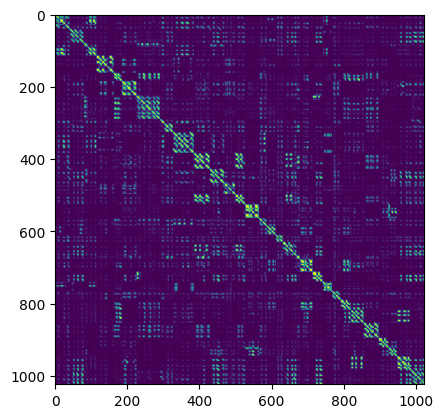

In [57]:
plt.imshow(out[...,0])

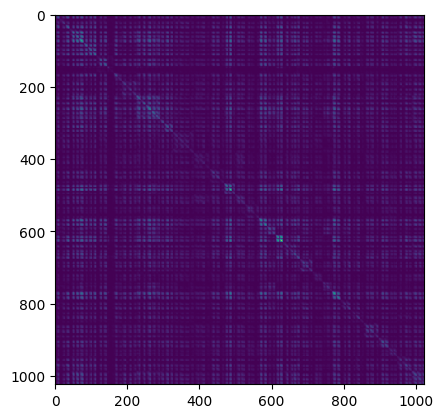

In [58]:
plt.imshow(out[...,1])

In [45]:
scores = out[...,0]

In [46]:
scores

array([[0.99999994, 0.99049497, 0.97739315, ..., 0.        , 0.        ,
        0.        ],
       [0.99049497, 1.        , 0.9927858 , ..., 0.        , 0.        ,
        0.        ],
       [0.97739315, 0.9927858 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.0000001 , 0.9210213 ,
        0.82129824],
       [0.        , 0.        , 0.        , ..., 0.9210213 , 1.0000002 ,
        0.9779625 ],
       [0.        , 0.        , 0.        , ..., 0.82129824, 0.9779625 ,
        0.99999994]], dtype=float32)

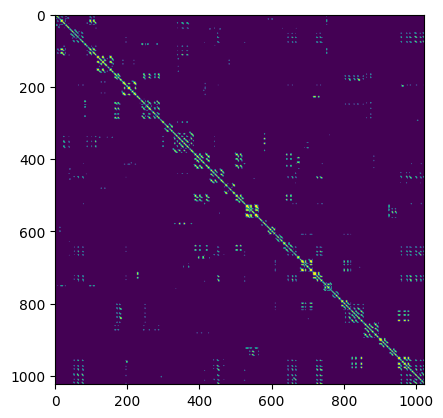

In [39]:
plt.imshow(mask)